In [1]:
# Install dependencies
!pip install torch-geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install seaborn optuna


Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html


In [2]:
# Import dependencies, check versions
import torch_geometric
import pandas as pd
import torch
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
# And some typing for code completion
from typing import Dict, List, Tuple, Union, Optional

print(torch.__version__)
print(torch_geometric.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on", device)

"""
Should be:
1.13.1
2.2.0
"""
pass


1.13.1
2.2.0
Running on cuda


In [4]:
# Dataset location
os.environ['DATASET_PATH'] = r'C:\Faks\MLG\MLGproject\dataset\elliptic_bitcoin_dataset' # Uncomment this to add own path
is_running_from_local = 'DATASET_PATH' in os.environ
if is_running_from_local:
    print('DATA_PATH: ', os.environ['DATASET_PATH'])
    DATASET_PATH = os.environ['DATASET_PATH']
else:
    from google.colab import drive
    drive.mount('/content/drive')  # Check: !ls drive/MyDrive/
    DATASET_PATH = 'drive/MyDrive/elliptic_bitcoin_dataset/'
    print("Reading from Google Colab")
    print('DATA_PATH: ', DATASET_PATH)


DATA_PATH:  C:\Faks\MLG\MLGproject\dataset\elliptic_bitcoin_dataset


In [5]:
# Reading data to DataFrames
classes = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_classes.csv", index_col="txId")
edgelist = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_edgelist.csv")

# index is on top level timestamp, second level txId
features = pd.read_csv(
    f"{DATASET_PATH}/elliptic_txs_features.csv", header=None, index_col=[1, 0])
features.index.names = ['timestamp', 'txId']

# That way, features are sorted by timestamp, as sample of first 5 columns shows:
display(features.loc[:, :5])

# TODO! Feature statistic/normalization

2         3         4          5
timestamp txId                                              
1         230425980 -0.171469 -0.184668 -1.201369  -0.121970
          5530458   -0.171484 -0.184668 -1.201369  -0.121970
          232022460 -0.172107 -0.184668 -1.201369  -0.121970
          232438397  0.163054  1.963790 -0.646376  12.409294
          230460314  1.011523 -0.081127 -1.201369   1.153668
...                       ...       ...       ...        ...
49        173077460 -0.145771 -0.163752  0.463609  -0.121970
          158577750 -0.165920 -0.123607  1.018602  -0.121970
          158375402 -0.172014 -0.078182  1.018602   0.028105
          158654197 -0.172842 -0.176622  1.018602  -0.121970
          157597225 -0.012037 -0.132276  0.463609  -0.121970

[203769 rows x 4 columns]

In [6]:
import seaborn as sns
sns.set_theme()

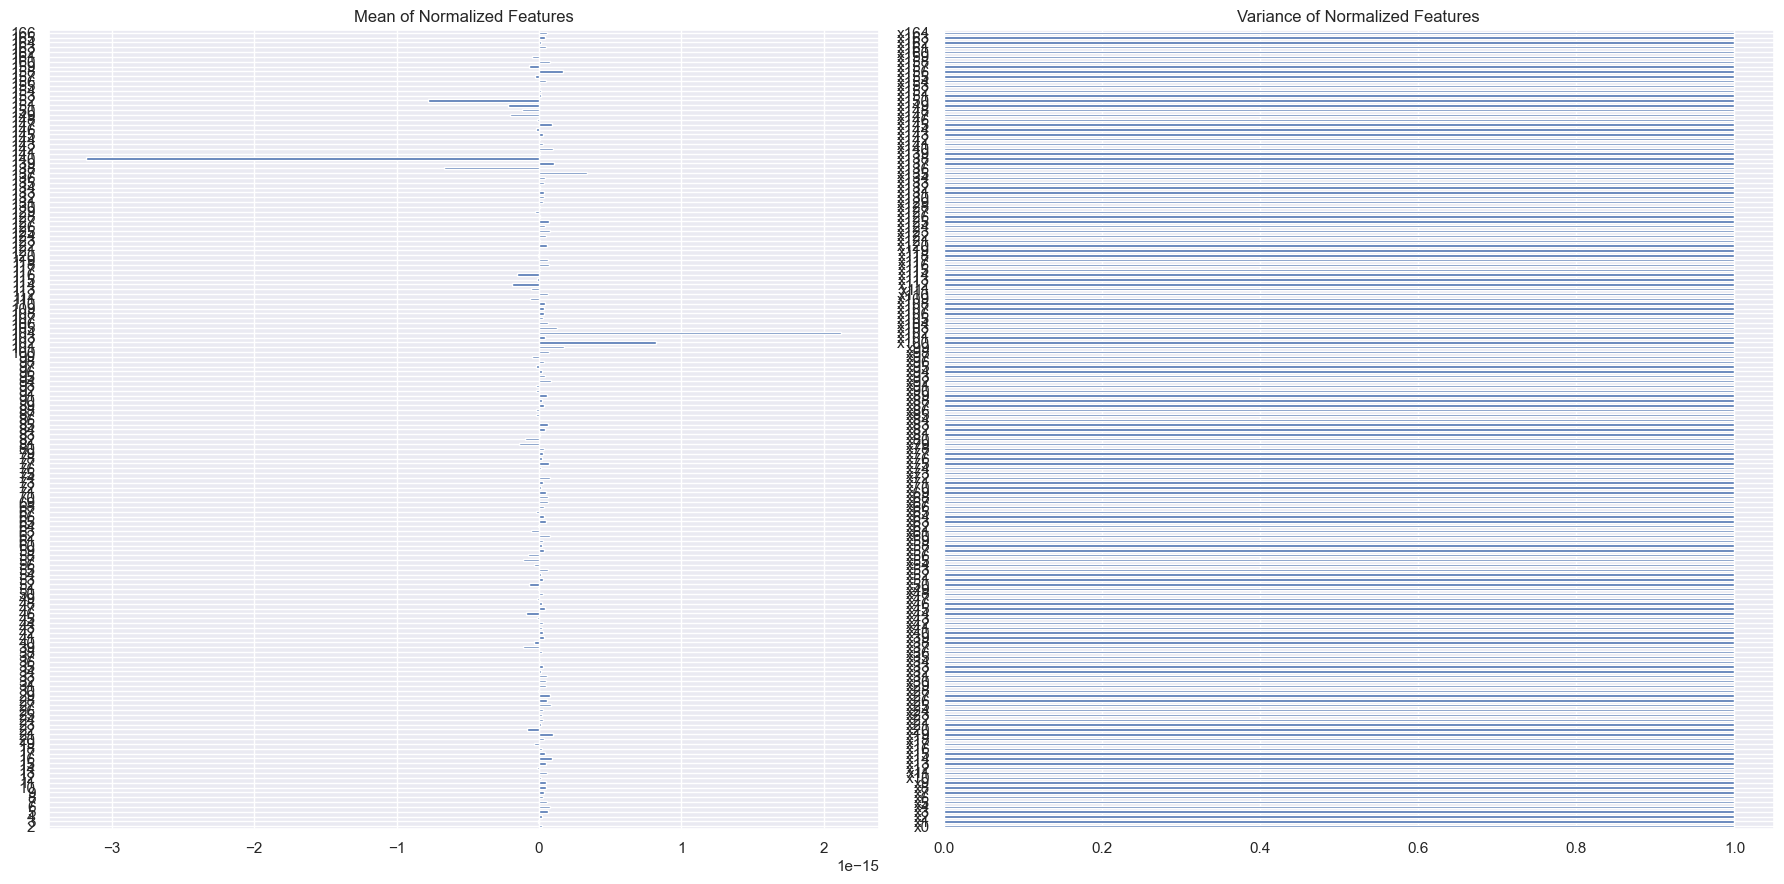

In [7]:
# feature normalization (mean = 0 && variance = 1)

# create the scaler object
scaler = StandardScaler(with_mean=False).set_output(transform="pandas")

# fit the scaler on the features
# normalize the features
normalize_features = scaler.fit_transform(features)

# Calculate the mean and variance of each feature
mean = features.mean()
variance = normalize_features.var()

# Plot the mean and variance of each feature
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
mean.plot.barh(y='mean')
plt.title('Mean of Normalized Features')
plt.subplot(1, 2, 2)
variance.plot.barh(y='variance')
plt.title('Variance of Normalized Features')
plt.tight_layout()
plt.show()

# TODO: we need somekind of a system to choose wheter we use normalized or original features for learning
# is visualization even required? it only shows that mean and var are actually what they need to be (interesting is that we have numerical errors visible at mean)

In [8]:
# Defining target classes
# Initial graph should be directed
directed_graph = nx.from_pandas_edgelist(
    edgelist, source='txId1', target='txId2', create_using=nx.DiGraph())
print(f"{nx.is_directed(directed_graph)=}")


ID_ILLICIT = 0  # Fraud
ID_LICIT = 1  # Legiet
ID_UNLABELED = 2 # Unknown

classes['y'] = classes['class'].replace(
    {'unknown': ID_UNLABELED, '1': ID_ILLICIT, '2': ID_LICIT})
class_mapping = classes[['y']].to_dict("dict")['y']

keys = features.index.get_level_values(1)
rows = torch.tensor(features.values, dtype=torch.double, device=device)
feature_mapping = dict(zip(keys, rows))


nx.is_directed(directed_graph)=True


In [9]:
# Subgraph splitting
timestamps = features.index.get_level_values(
    0).unique().sort_values().to_list()
ts_Tid_df = features.index.to_frame(index=False)
dataset = []
for ts in timestamps:
    # Get all txIds for a given timestamp
    sub_graph_idx = ts_Tid_df[ts_Tid_df.timestamp == ts].txId.to_list()
    # Create subgraph from the original graph
    s = directed_graph.subgraph(sub_graph_idx)
    nx.set_node_attributes(s, class_mapping, "y")
    nx.set_node_attributes(s, feature_mapping, "x")

    dataset.append(s)

# Takes ~20sec to run


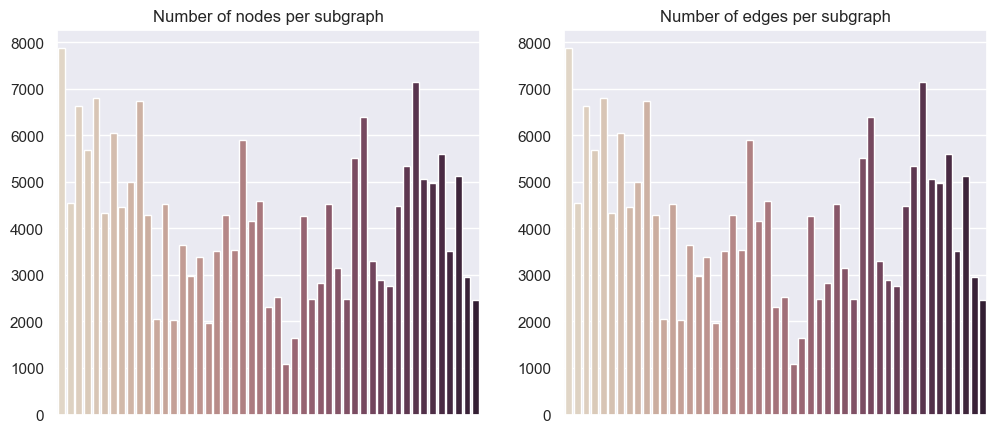

In [10]:
# Vertex/Edge count
node_dict = {i: len(subgraph.nodes) for i, subgraph in enumerate(dataset)}
edge_dict = {i: len(subgraph.edges) for i, subgraph in enumerate(dataset)}

# using seaborn implementation
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,5))
node_indices = list(node_dict.keys())
node_count = list(node_dict.values())
nodes_graph = sns.barplot(ax=axes[0], x=node_indices, y=node_count, palette="ch:.25")
nodes_graph.set(xticklabels=[])
nodes_graph.set_title("Number of nodes per subgraph")

edge_indices = list(edge_dict.keys())
edge_count = list(edge_dict.values())
edge_graph = sns.barplot(ax=axes[1], x=node_indices, y=node_count, palette="ch:.25")
edge_graph.set(xticklabels=[])
_x = edge_graph.set_title("Number of edges per subgraph")


In [11]:
# Displaying the smallest subgraph
min_idx = min(node_dict, key=node_dict.get)
smallest_subgraph = dataset[min_idx]
labeled_nodes = [x for x,y in smallest_subgraph.nodes(data=True) if y['y']!=ID_UNLABELED]
labeled_graph = nx.induced_subgraph(smallest_subgraph, labeled_nodes)

palette = sns.color_palette("husl", 8)
color_map = {ID_UNLABELED: "gray", ID_LICIT: palette[2], ID_ILLICIT: palette[5]}
colors_labled = [color_map[attrs["y"]] for _, attrs in labeled_graph.nodes(data=True)]
colors_full = [color_map[attrs["y"]] for _, attrs in smallest_subgraph.nodes(data=True)]

fig1 = plt.figure(figsize=(10,10)) 
nx.draw_random(labeled_graph, node_color=colors_labled, node_size=250, linewidths=5, edge_color="black", alpha=0.5)

fig2 = plt.figure(figsize=(10,10))
nx.draw(smallest_subgraph, node_color=colors_full, node_size=30, linewidths=2, edge_color="black", alpha=0.5)

_x = fig1.suptitle("Graph with the smallest number of nodes: LABELED")
_x = fig2.suptitle("Graph with the smallest number of nodes: UNLABELED")


TypeError: '_AxesStack' object is not callable

<Figure size 1000x1000 with 0 Axes>

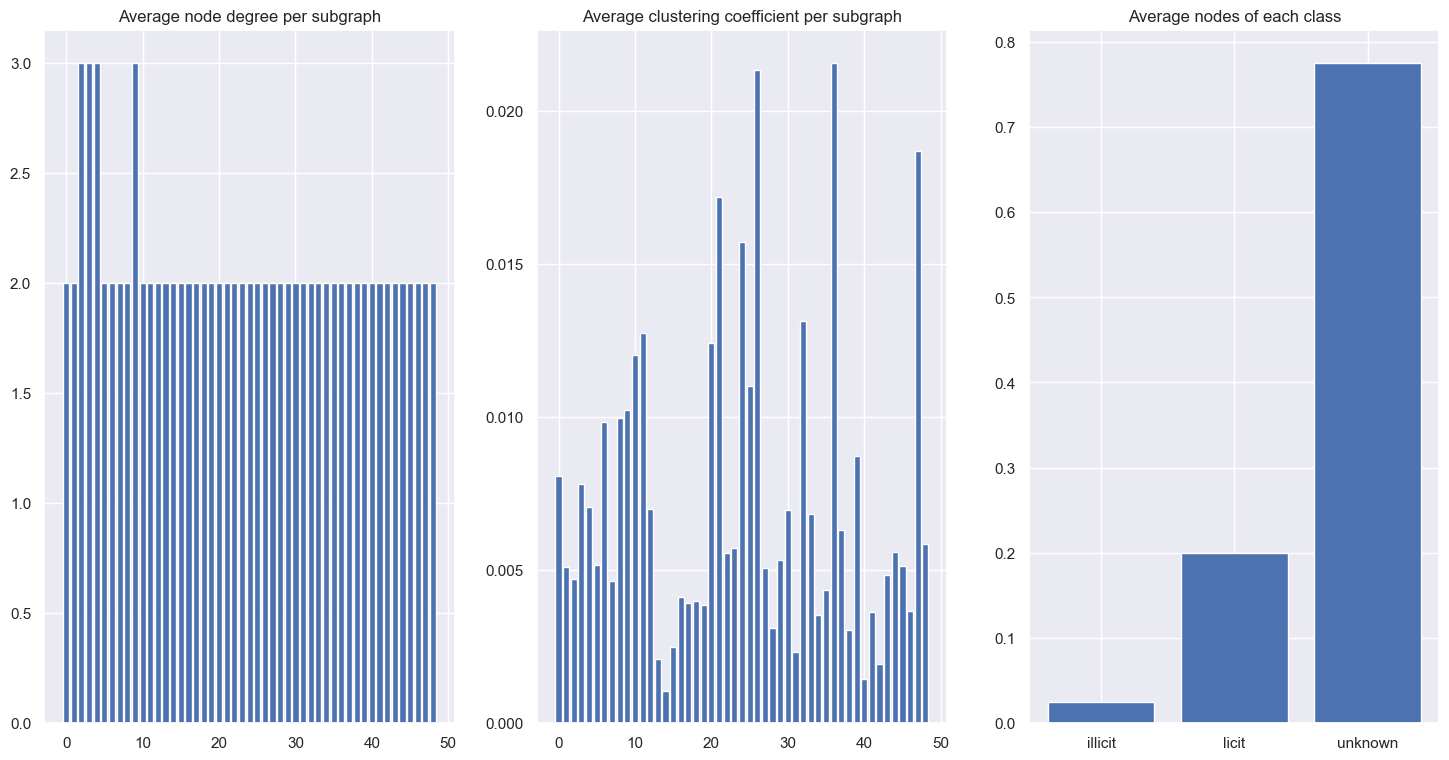

In [12]:
# some graph analysis
node_counter = np.array(list(node_dict.values()))
edge_counter = np.array(list(edge_dict.values()))
# a ma avg_degree sploh smisel, glede na to da so to transakcije? čeprov ne vem zakaj bi eni nodi mel degree > 2
avg_degree = np.round(2 * (edge_counter) / (node_counter))
avg_cluster_coef = np.round([nx.average_clustering(subgraph) for subgraph in dataset], 5)
no_of_classes = [np.bincount([attrs["y"] for _, attrs in subgraph.nodes(data=True)]) for subgraph in dataset]
avg_node_class = np.mean([[i / sum(x) for i in x]for x in no_of_classes], axis=0)
# print("average degrees:", avg_degree)
# print("average clustering coefficients:", avg_cluster_coef)
# print("number of nodes of each class in each of the subgraphs:", no_of_classes)

plt.figure(figsize=(18, 9))
plt.subplot(1, 3, 1)
plt.bar(np.arange(len(dataset)), avg_degree)
plt.title("Average node degree per subgraph")

plt.subplot(1, 3, 2)
plt.bar(np.arange(len(dataset)), avg_cluster_coef)
plt.title("Average clustering coefficient per subgraph")

plt.subplot(1, 3, 3)
plt.bar(["illicit", "licit", "unknown"], avg_node_class)
plt.title("Average nodes of each class")

plt.show()
#todo: use Nina's sns configuration for histograms. (nimam zdele časa, grem na faks)

In [13]:
# Model definition
from torch_geometric.nn import GCNConv, GATConv, BatchNorm
import torch.nn as nn
import torch.nn.functional as F

class SM2_GCN(torch.nn.Module):
    def __init__(self,
                 in_channels: int,
                 hidden_channels: int,
                 out_channels: int,
                 conv_model: type[nn.Module],
                 nonlinearity: nn.Module,
                 num_hidden: int = 3,
                 conv_args: Dict = {},
                 dropout: float = 0.5):
        super(SM2_GCN, self).__init__()

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(
            conv_model(in_channels, hidden_channels, **conv_args)
        )
        self.bns.append(BatchNorm(hidden_channels))
        for _ in range(num_hidden):  # TODO!: BatchNorm or LayerNorm?
            self.convs.append(
                conv_model(hidden_channels, hidden_channels, **conv_args))
            self.bns.append(BatchNorm(hidden_channels))

        self.convs.append(
            conv_model(hidden_channels, out_channels, **conv_args))
        self.bns.append(BatchNorm(hidden_channels))

        self.dropout = dropout
        self.nonlinearity = nonlinearity

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            # TODO! Check dimensionality of x after GCNConv and GATConv
            x = self.nonlinearity(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if i < len(self.convs) - 1:
                x = self.bns[i](x)
        x = F.softmax(x, dim=1)
        return x


In [98]:
# Testing Config
from dataclasses import dataclass, asdict, field

import json
import re


class SerializableConfig:

    @classmethod
    def load(cls, fname: str):
        with open(fname) as f:
            return cls(**json.load(f))

    def save(self, fname: str):
        with open(fname, 'w') as f:
            json.dump(asdict(self), f, indent=4)
        return self

    @classmethod
    def from_dict(cls, d: dict):
        # only take the keys that are in the dataclass
        d = {k: v for k, v in d.items() if k in cls.__dataclass_fields__}
        return cls(**d)


@dataclass
class TrainConfig(SerializableConfig):
    num_epoch: int = 10
    batch_size: int = 32
    test_split: float = 0.2
    random_state: Optional[int] = None

    # Optimizer
    optimizer_name: str = 'adam'
    lr: float = 0.01
    weight_decay: float = 5e-4

    def get_optimizer_for(self, model):
        if self.optimizer_name == 'adam':
            return torch.optim.Adam(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        elif self.optimizer_name == 'sgd':
            return torch.optim.SGD(model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        else:
            raise ValueError(f"Unknown optimizer name: {self.optimizer_name}")

    # Loss
    loss_name: str = 'cross_entropy'
    # Beacuse of the class imbalance, we want to give more weight to the ID_LICIT class
    class_weight: float = 0.80
    
    def get_loss(self):
        class_weights = torch.Tensor([self.class_weight, 1 - self.class_weight], device=device)
        if self.loss_name == 'cross_entropy':
            return torch.nn.CrossEntropyLoss(weight=class_weights)
        if self.loss_name == 'bce':
            return torch.nn.BCEWithLogitsLoss(weight=class_weights)
        else:
            raise ValueError(f"Unknown loss name: {self.loss_name}")


In [99]:
# Data loaders
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
from sklearn.model_selection import train_test_split


def split_and_create_loaders(config: TrainConfig, dataset: List[nx.Graph]) -> Tuple[Tuple[List, List], Tuple[DataLoader, DataLoader]]:
    X_graphs = []
    for subgraph in dataset:
        _x = from_networkx(subgraph)
        _x.x = _x.x.to(device)
        _x.y = _x.y.to(device)
        X_graphs.append(_x)
    X_train, X_test = train_test_split(
        X_graphs, test_size=config.test_split, random_state=config.random_state)
    train_loader = DataLoader(
        X_train, batch_size=config.batch_size)
    test_loader = DataLoader(X_test, batch_size=1)
    return (X_train, X_test), (train_loader, test_loader)


In [112]:
# Train
from tqdm.notebook import trange, tqdm


def log(epoch, loss, best, one_line: bool = False):
    if loss < best[1]:
        best = (epoch, loss)
    best_epoch, best_loss = best
    s = f"Epoch: {epoch} | Loss: {loss:.4f} | Best loss: {best_loss:.4f} @ Epoch {best_epoch}"
    s = f"\r{s}" if one_line else f"{s}\n"
    tqdm.write(s, end="")


def train(model: SM2_GCN, data_loader: DataLoader, config: TrainConfig, shortlog: bool = False):
    best_tuple = (-1, np.inf)
    dataset = data_loader.dataset
    loss_fn = config.get_loss()
    optimizer = config.get_optimizer_for(model)
    model.to(device)
    model.reset_parameters()
    model.train()
    for epoch in trange(config.num_epoch, unit="Epochs", desc="Training"):
        epoch_loss = 0

        for batch in data_loader:
            optimizer.zero_grad()

            batch.to(device)
            out = model(batch.x.float(), batch.edge_index)
            labeled_mask = (batch.y != ID_UNLABELED)
            loss = loss_fn(out[labeled_mask],
                           batch.y[labeled_mask])
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch.num_graphs
        avg_epoch_loss = epoch_loss / len(dataset)
        log(epoch, avg_epoch_loss, best_tuple, one_line=shortlog)
    print()


In [113]:
# Test
from sklearn.metrics import accuracy_score, f1_score, roc_curve


@torch.no_grad()
def test(model: nn.Module, data_loader: DataLoader,
         in_kfold: bool = False):
    model.to(device)
    model.eval()

    all_y = np.array([])
    all_predicted = np.array([])
    all_predicted_is_1 = np.array([])

    for batch in tqdm(data_loader, unit="Test cases", desc="Testing"):
        batch.to(device)
        out = model(batch.x.float(), batch.edge_index)
        label_mask = batch.y != ID_UNLABELED


        predictions = out[label_mask].argmax(dim=1).to('cpu').numpy()
        all_predicted = np.append(all_predicted, predictions)

        y = batch.y[label_mask].to('cpu').numpy()
        all_y = np.append(all_y, y)

        if not in_kfold:
            # Compute ROC curve and ROC area for class 1 = ID_LICIT
            predicted_is_1 = out[label_mask][:, 1].to('cpu').numpy()
            all_predicted_is_1 = np.append(all_predicted_is_1, predicted_is_1)
            
            acc = accuracy_score(y, predictions)
            f1 = f1_score(y, predictions, average="macro")
            print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")

    all_f1 = f1_score(all_y, all_predicted, average="macro")

    if not in_kfold:
        acc = accuracy_score(all_y, all_predicted)
        f1 = f1_score(all_y, all_predicted, average="macro")
        print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")
        print(
            f"Real ratio of licit: {len(all_y[all_y == ID_LICIT])/len(all_y)}",
            f"Predicted ratio of licit: {len(all_predicted[all_predicted == ID_LICIT])/len(all_predicted)}")
        fpr, tpr, _ = roc_curve(all_y, all_predicted_is_1)
        plt.plot(fpr, tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

    return all_f1


In [118]:
# Model Config

@dataclass
class ModelConfig(SerializableConfig):
    in_channels: int = -1
    hidden_channels: int = 64
    out_channels: int = 2
    num_hidden: int = 3
    conv_model: str = "GATConv(4)"
    conv_args: dict = field(default_factory=dict)
    dropout: float = 0.5
    nonlinearity: str = 'leaky_relu(0.2)'

    def __nonlinearity(self):
        if self.nonlinearity == 'relu':
            return nn.ReLU()
        leakyrelu_re = re.match(r'leaky_relu\((\d+\.?\d*)\)', self.nonlinearity)
        if leakyrelu_re:
            return nn.LeakyReLU(float(leakyrelu_re.group(1)))
        if self.nonlinearity == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unknown nonlinearity: {self.nonlinearity}")

    def __model_type(self):
        gatconv_re = re.match(r'GATConv\((\d+)\)', self.conv_model)
        if gatconv_re:
            heads = int(gatconv_re.group(1))
            self.conv_args.update({"concat": False, "heads": heads})
            return GATConv
        elif self.conv_model == "GCNConv":
            return GCNConv
        else:
            raise ValueError(f"Unknown model type: {self.conv_model}")

    def create(self):
        return SM2_GCN(in_channels=self.in_channels,
                       hidden_channels=self.hidden_channels,
                       out_channels=self.out_channels,
                       num_hidden=self.num_hidden,
                       conv_model=self.__model_type(),
                       conv_args=self.conv_args, dropout=self.dropout,
                       nonlinearity=self.__nonlinearity()
                )


Training:   0%|          | 0/8 [00:00<?, ?Epochs/s]

Epoch: 7 | Loss: 0.5930 | Best loss: 0.5930 @ Epoch 7Base-predictor, with some default hyper-parameter values


Testing:   0%|          | 0/10 [00:00<?, ?Test cases/s]

Accuracy: 0.8033, F1: 0.7636
Accuracy: 0.8414, F1: 0.7266
Accuracy: 0.9274, F1: 0.7224
Accuracy: 0.9024, F1: 0.7201
Accuracy: 0.8635, F1: 0.6863
Accuracy: 0.8189, F1: 0.7554
Accuracy: 0.9058, F1: 0.4903
Accuracy: 0.8859, F1: 0.8028
Accuracy: 0.9320, F1: 0.5146
Accuracy: 0.8638, F1: 0.7371
Accuracy: 0.8829, F1: 0.7272
Real ratio: 0.8872559771879798, Pred ratio: 0.8681728449221321


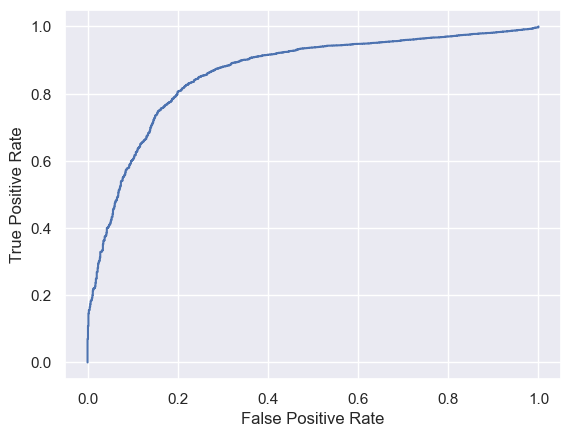

F1 score: 0.7272


In [120]:
# All together


fname = 'local_training_config.json'
try:
    config = TrainConfig.load(fname)
except FileNotFoundError:
    config = TrainConfig(
        num_epoch=10,
        batch_size=32,
        test_split=0.2,
        optimizer_name='adam',
        lr=0.01,
        weight_decay=5e-4,
        loss_name='cross_entropy'
    ).save(fname)

fname = 'local_model_config.json'
try:
    model_config = ModelConfig.load(fname)
except FileNotFoundError:
    model_config = ModelConfig(
        hidden_channels=64,
        num_hidden=3,
        conv_model='GATConv',
        dropout=0.5,
        nonlinearity='leaky_relu(0.2)').save(fname)

model = model_config.create()
_, (train_loader, test_loader) = split_and_create_loaders(config, dataset)
train(model, train_loader, config, shortlog=True)
print("Base-predictor, with some default hyper-parameter values")
f1 = test(model, test_loader)
print(f"F1 score: {f1:.4f}")


In [104]:
# K-Fold Cross Validation
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import RepeatedKFold
from tqdm.notebook import tqdm


def kfold(model, config: TrainConfig, train_dataset:List, n_splits=5, n_repeats=1):
    f1_history = []
    rkfold_splitter = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)

    for (train_idx, val_idx) in tqdm(rkfold_splitter.split(train_dataset), total=n_splits*n_repeats, desc="K-Fold"):
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(
            train_dataset, batch_size=config.batch_size, sampler=train_sampler)
        valid_loader = DataLoader(
            train_dataset, batch_size=config.batch_size, sampler=valid_sampler)
        train(model, train_loader, config, shortlog=True)
        f1 = test(model, valid_loader, in_kfold=True)
        f1_history.append(f1)
    avg_test_f1 = np.mean(f1_history)
    print(f"Average F1: {avg_test_f1}")
    return avg_test_f1



In [109]:
# Hyperparameter search
import optuna
from optuna.samplers import TPESampler


def objective(trial):
    global X_train
    model_config = ModelConfig(
        hidden_channels=trial.suggest_int('hidden_channels', 2, 6),
        num_hidden=trial.suggest_int('num_hidden', 1, 4),
        conv_model=trial.suggest_categorical(
            'conv_model', ['GATConv(1)', 'GATConv(2)', 'GATConv(3)', 'GATConv(4)', 'GCNConv']),
        conv_args={},
        dropout=trial.suggest_float('dropout', 0.1, 0.5),
        nonlinearity=trial.suggest_categorical(
            'nonlinearity', ['relu', 'leaky_relu(0.2)', 'sigmoid'])
    )
    config = TrainConfig(
        num_epoch=64,
        batch_size=8,
        test_split=0.2,  # Not used in kfold
        optimizer_name='adam',
        lr=trial.suggest_float('lr', 1e-4, 1e-1, log=True),
        weight_decay=trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True),
        loss_name='cross_entropy',
        class_weight=trial.suggest_float('class_weight', 0.6, 0.9, log=True)
    )
    model = model_config.create()
    return kfold(model, config, X_train, n_splits=5)


(X_train, _), (loader_X_train, loader_X_test) = split_and_create_loaders(config, dataset)
study = optuna.create_study(direction='maximize', sampler=TPESampler())

try:
    study.optimize(objective, n_trials=80, show_progress_bar=True)
except KeyboardInterrupt:
    pass
except Exception as e:
    print(e)


[I 2023-03-25 18:21:47,826] A new study created in memory with name: no-name-c10ee5fc-9861-4770-86cc-be3d58484a26
c:\Users\aljaz\anaconda3\envs\mlg_env\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

Creating model from config
ModelConfig(in_channels=-1, hidden_channels=6, out_channels=2, num_hidden=1, conv_model='GATConv(4)', conv_args={}, dropout=0.4173143084173726, nonlinearity='leaky_relu(0.2)')


K-Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/4 [00:00<?, ?Epochs/s]

Epoch: 3 | Loss: 0.5448 | Best:0.5448 @3

Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/4 [00:00<?, ?Epochs/s]

Epoch: 3 | Loss: 0.5575 | Best:0.5575 @3

Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/4 [00:00<?, ?Epochs/s]

Epoch: 3 | Loss: 0.5433 | Best:0.5433 @3

Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/4 [00:00<?, ?Epochs/s]

Epoch: 3 | Loss: 0.5647 | Best:0.5647 @3

Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Training:   0%|          | 0/4 [00:00<?, ?Epochs/s]

Epoch: 3 | Loss: 0.5801 | Best:0.5801 @3

Testing:   0%|          | 0/1 [00:00<?, ?Test cases/s]

Average F1: 0.46728556130439297
[I 2023-03-25 18:21:52,264] Trial 0 finished with value: 0.46728556130439297 and parameters: {'hidden_channels': 6, 'num_hidden': 1, 'conv_model': 'GATConv(4)', 'dropout': 0.4173143084173726, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.00019607112779093362, 'weight_decay': 2.1813000220535568e-05}. Best is trial 0 with value: 0.46728556130439297.


In [123]:
# Report on the best trial

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

best_model_conf = ModelConfig.from_dict(study.best_trial.params)\
    .save('local_best_model_config.json')
best_training_conf = TrainConfig.from_dict(study.best_trial.params)\
    .save('local_best_train_config.json')


Number of finished trials: 1
Best trial: {'hidden_channels': 6, 'num_hidden': 1, 'conv_model': 'GATConv(4)', 'dropout': 0.4173143084173726, 'nonlinearity': 'leaky_relu(0.2)', 'lr': 0.00019607112779093362, 'weight_decay': 2.1813000220535568e-05}
Best value: 0.46728556130439297


Training:   0%|          | 0/10 [00:00<?, ?Epochs/s]

Epoch: 9 | Loss: 0.6879 | Best loss: 0.6879 @ Epoch 9

Testing:   0%|          | 0/10 [00:00<?, ?Test cases/s]

Accuracy: 0.4281, F1: 0.3999
Accuracy: 0.5710, F1: 0.5297
Accuracy: 0.5071, F1: 0.4552
Accuracy: 0.4315, F1: 0.3202
Accuracy: 0.5262, F1: 0.4463
Accuracy: 0.3381, F1: 0.2596
Accuracy: 0.5162, F1: 0.5050
Accuracy: 0.5474, F1: 0.5251
Accuracy: 0.3371, F1: 0.2537
Accuracy: 0.5786, F1: 0.3700
Accuracy: 0.4890, F1: 0.4142
Real ratio: 0.9186515558970418, Pred ratio: 0.43853246254321937


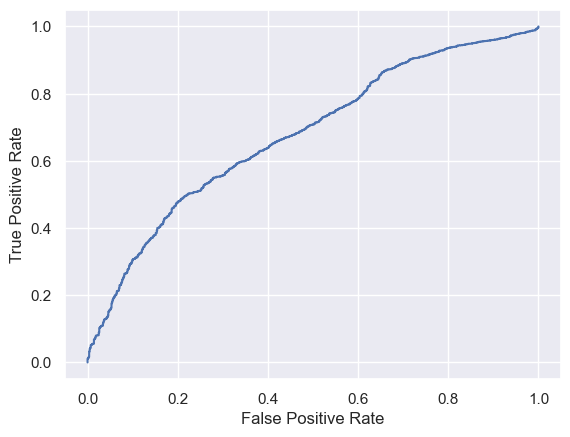

Final F1 score: 0.4142


In [124]:
# Training with best hyperparameters on the whole dataset
model = best_model_conf.create()
train(model, loader_X_train, best_training_conf, shortlog=True)
f1=test(model, loader_X_test)
print(f"Final F1 score: {f1:.4f}")